In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import string as string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
# uncomment if required
nltk.download('stopwords')
nltk.download('punkt')
# nltk.download('words')
# nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [327]:
df = pd.read_csv('fake.csv')

In [328]:
#Create a new column 'post_engagement' which is the sum of the 'likes', 'comments', and 'shares' columns

#sum_list = ['likes', 'comments', 'shares']
#df['post_engagement'] = df[sum_list].sum(axis=1)

In [329]:
#Checking how many null entries in each column

df.isnull().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

In [330]:
#Zooming in on "country" column, "US" is the most common entry

df.country.value_counts()

US    10367
GB      831
RU      400
DE      224
FR      207
TV      201
EU      112
CA      103
IS      100
ES      100
NL       55
ME       34
IN       23
BG       19
CO       17
LI       10
IR        7
EE        4
ZA        3
SG        2
IO        1
SE        1
AU        1
CH        1
Name: country, dtype: int64

In [331]:
#Filling null entries in "country" column with "US" as it is the most common

df.country.fillna("US", inplace=True)

In [332]:
#Remove countries that have less than 20 entries

value_counts = df.country.value_counts()
to_remove = value_counts[value_counts<20].index
df.replace(to_remove, np.nan, inplace = True)

In [333]:
df.language.value_counts()

english       12403
russian         203
spanish         172
german          111
french           38
arabic           22
portuguese       11
turkish          10
italian           9
ignore            7
greek             4
dutch             3
norwegian         3
finnish           1
chinese           1
polish            1
Name: language, dtype: int64

In [334]:
#Remove all non-english entries as there are too few

df = df[df.language == 'english']

In [335]:
#Dropping columns that will not be used

df = df.drop(['uuid', 'language', 'crawled', 'published', 'ord_in_thread', 'domain_rank', 'main_img_url', 'thread_title'], axis = 1)

# EDA

Correlation matrix for numerical attributes

Correlation

In [336]:
corrData = pd.DataFrame(df[['spam_score', 'replies_count', 'participants_count', 'likes', 'comments', 'shares']])
corrData.head()

,spam_score,replies_count,participants_count,likes,comments,shares
0,0.000,0,1,0,0,0
1,0.000,0,1,0,0,0
2,0.000,0,1,0,0,0
3,0.068,0,0,0,0,0
4,0.865,0,0,0,0,0


<AxesSubplot:>

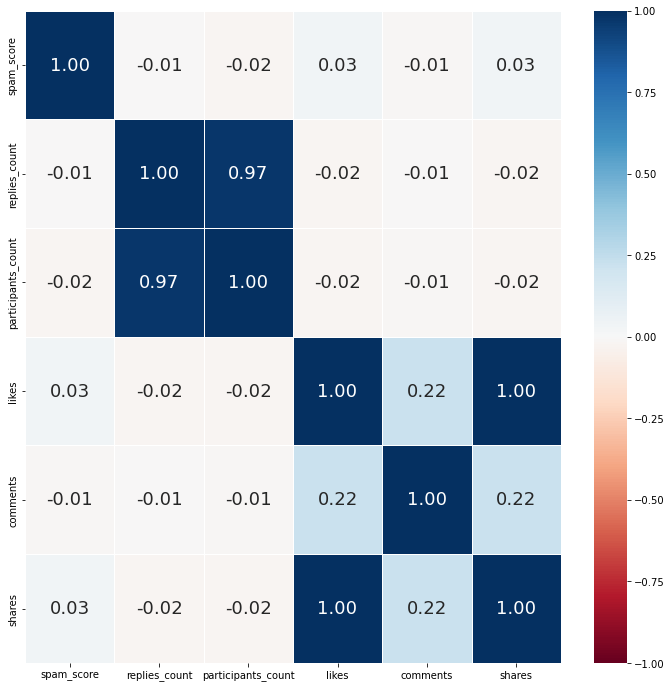

In [337]:
corrData = pd.concat([corrData, df["spam_score"]], axis = 1).reindex(df.index)

#print(df.corr())

f = plt.figure(figsize=(12, 12))

sb.heatmap(df.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

We can see from the plot that the participation count had the strongest negative correlation, meaning that if there were more participants for a given news thread, then that was an indication that it is not a fake news thread.

As for other factors like reply count, likes, comments and shares have a weaker correlation but show that the greater engagement with the particular post would suggest that it would have a lower spam score.

The result from the correlation implies that variables that measure more particpation and/or engagement with a particular post could hint to be the authenticity of the thread and ascertain a spam score.

Spam score frequency

<AxesSubplot:>

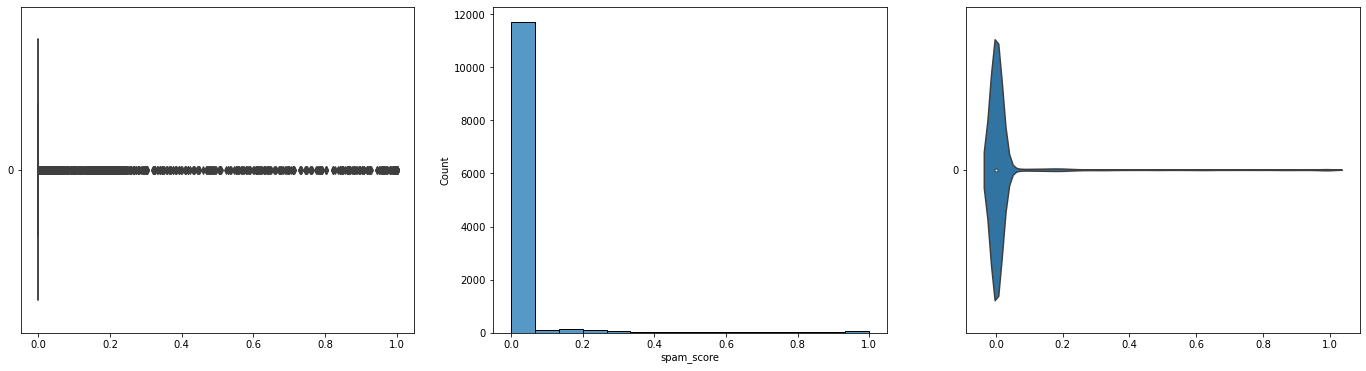

In [338]:
#Too many 0s for spam_score

f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = df.spam_score, orient = "h", ax = axes[0])
sb.histplot(data = df.spam_score, ax = axes[1])
sb.violinplot(data = df.spam_score, orient = "h", ax = axes[2])

In [339]:
#Remove 0 rows in spam_score to eliminate skewness (considering if we should remove the 0s?)

df = df[df.spam_score != 0]
spam = pd.DataFrame(df['spam_score'])

<AxesSubplot:>

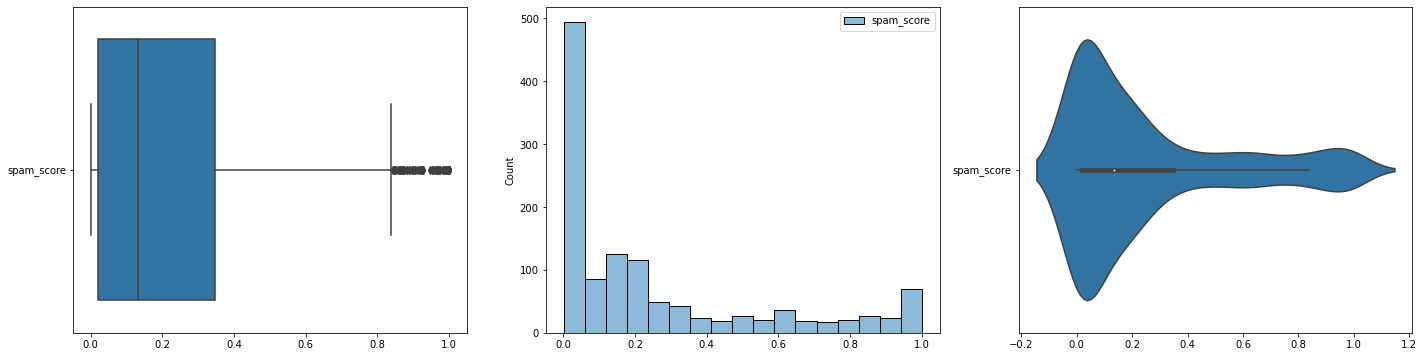

In [340]:
f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = spam, orient = "h", ax = axes[0])
sb.histplot(data = spam, ax = axes[1])
sb.violinplot(data = spam, orient = "h", ax = axes[2])

In [341]:
#Converting values of spam_score from numeric to categorical where 
#spam_score <= 0.3 is changed to 'low'
#0.3 < spam_score <= 0.6 is changed to 'medium'
#spam_score > 0.6 is changed to 'high'

df.loc[(df.spam_score <= 0.3) & (df.spam_score > 0), 'spam_score'] = 0.3
df.loc[(df.spam_score > 0.3) & (df.spam_score <= 0.6), 'spam_score'] = 0.6
df.loc[(df.spam_score > 0.6), 'spam_score'] = 1

#df.loc[(df.spam_score == 0), 'spam_score'] = 'zero'
df.loc[(df.spam_score == 0.3), 'spam_score'] = 'low'
df.loc[(df.spam_score == 0.6), 'spam_score'] = 'medium'
df.loc[(df.spam_score == 1), 'spam_score'] = 'high'

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



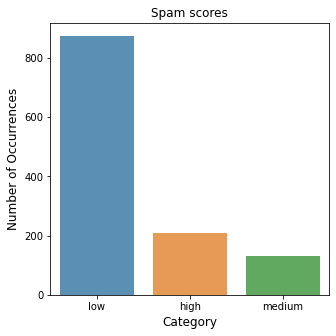

In [342]:
a = df["spam_score"].value_counts()
plt.figure(figsize=(5,5))
sb.barplot(a.index, a.values, alpha=0.8)
plt.title('Spam scores')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

This visualisation can be used to gauge how many news thread have been assiged a low, medium, or high spam scores

Spam frequency by authors

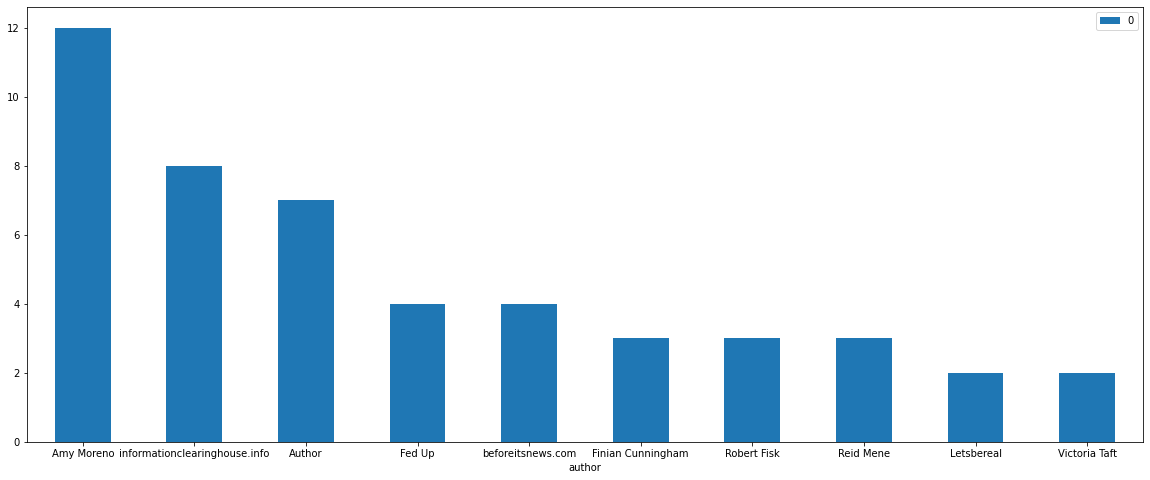

In [343]:
spamHigh = df[df['spam_score']=='high']
s = pd.DataFrame(spamHigh.value_counts('author'))
s = s.head(10)
s = s.reset_index()

ax = s.plot.bar(x='author', y=0, rot=0, figsize=(20,8))

Bar graph for high spam score

The top writer Amy Moreno can also be seen in the low and medium bracket, suggesting it might be the content the writer uploads would have incurred a higher spam score. Other unnamed writers that include “author” can also be seen in both of the brackets i.e high and below.

The one author that sounds out in the higher spam score is the information clearing house where it can’t be seen in the lower bracket for spam score indicates this news source is a potential hub for the spread of misinformation.

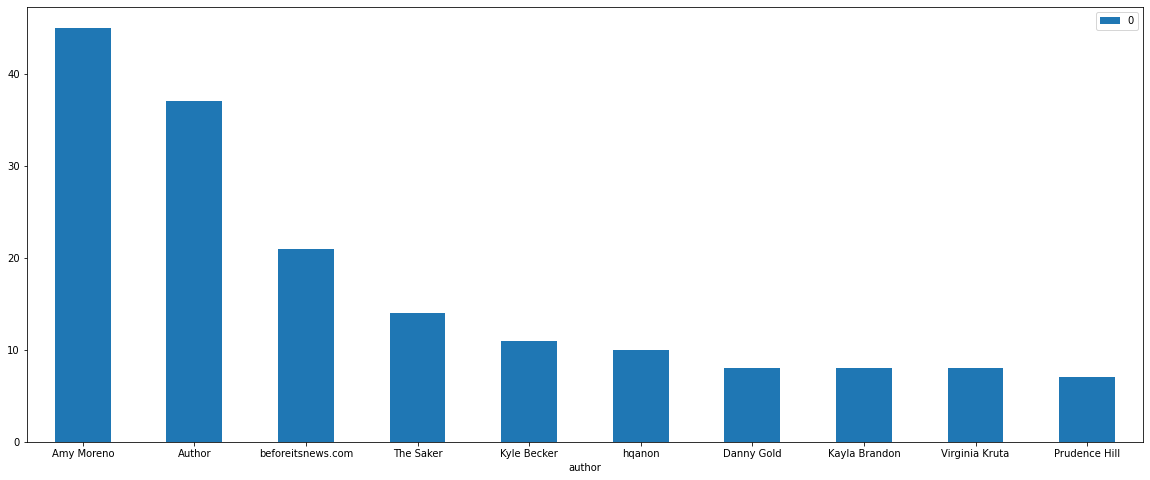

In [344]:
spamNotHigh = df[df['spam_score']!='high']
s = pd.DataFrame(spamNotHigh.value_counts('author'))
s = s.head(10)
s = s.reset_index()

ax = s.plot.bar(x='author', y=0, rot=0, figsize=(20,8))

Bar graph for low and medium spam score

Title effect on spam score

Titles of the threads posted with fake news are meant to lure the user so they click the news title and get directed to the news text. The counts of the top words in the title with high spam score show that it mostly contains buzz words such as “wwiii” (world war three) and a large number of the word “yuge” which was a term associated with Donald Trump for his accent, hints to the nature of the fake news being mostly targeted at politics and current affairs.

In [347]:
#list of text documents
text = df['title'].to_list()
#create the transform
vectorizer = TfidfVectorizer()
#tokenize and build vocab
vectorizer.fit(text)
#summarize
#print(vectorizer.vocabulary_)

ValueError: np.nan is an invalid document, expected byte or unicode string.

Country wise frequency

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



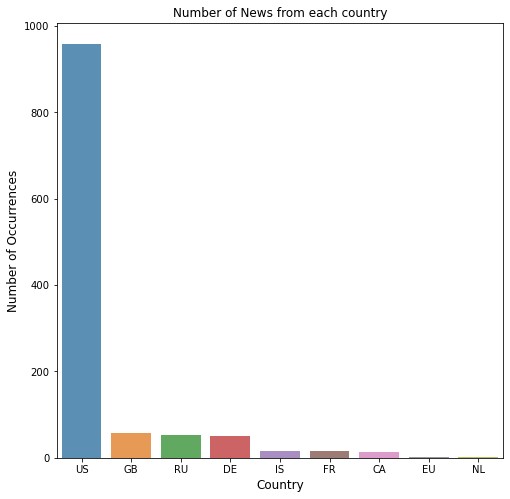

In [316]:
a = df["country"].value_counts()
plt.figure(figsize=(8,8))
sb.barplot(a.index, a.values, alpha = 0.8)
plt.title('Number of News from each country')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Country', fontsize = 12)
plt.show()

The graph can be used to gauge how many threads are from which country. This will help us understand which country has the most fake news threads.

The US has the most number by a large margin.

Relationship between Spam scores and the usage of Punctuation marks in the title

In [318]:
temp_df = pd.DataFrame()
temp_df["title"] = df["title"]
temp_df["spam_score"] = df["spam_score"]

count = lambda l1,l2: sum([1 for x in l1 if x in l2])
temp_df['count_punct'] = df.title.apply(lambda s: count(s, string.punctuation))

i = 0
for x in temp_df.count_punct:
    if type(x) != str:
        if x<=1:
            temp_df['count_punct'][i] = "Low"
        elif x<=4:
            temp_df['count_punct'][i] = "Medium"
        else:
            temp_df['count_punct'][i] = "High"
    i = i+1
    
temp_df = temp_df.groupby(['spam_score', 'count_punct']).size()
temp_df = temp_df.unstack()
temp_df.plot(kind='bar')

plt.ylabel('Count', fontsize = 12)
plt.xlabel('Spam Score', fontsize = 12)
plt.title('Relationship between Spam scores and Usage of Punctuation Marks')
plt.show()

TypeError: 'float' object is not iterable

Spam frequency by URLs

A possible insight could be whichh URLs had the highest number of High spam scores attributed to them.

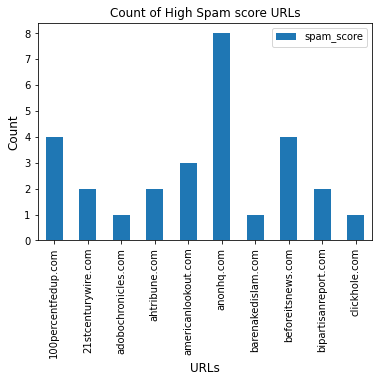

In [320]:
tempURL_df = pd.DataFrame()
tempURL_df["site_url"] = df["site_url"]
tempURL_df["spam_score"] = df["spam_score"]

tempURL_df = tempURL_df[tempURL_df['spam_score'] == 'high']
count_df = tempURL_df.groupby(['site_url']).count()

count_df = pd.DataFrame(count_df).head(10)


count_df.plot(kind='bar')
plt.ylabel('Count', fontsize = 12)
plt.xlabel('URLs', fontsize = 12)
plt.title('Count of High Spam score URLs')
plt.show()

It can be seen that the Website URLs, "anonhq.com" has the highest frequency of High Spam Scores attributed to them, suggesting that either the content put up on these websites or the kind of writers who put up the content, might be such that falls under the category of spam, thereby incurring a high spam score.

Spam frequency by engagement

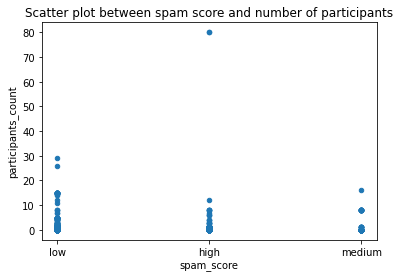

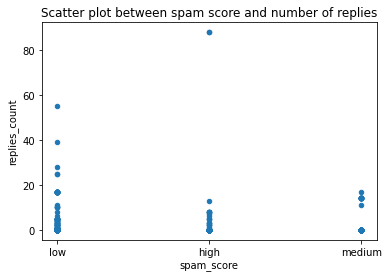

In [321]:
df.plot.scatter(x='spam_score', y='participants_count', title = "Scatter plot between spam score and number of participants")
df.plot.scatter(x='spam_score', y='replies_count', title = "Scatter plot between spam score and number of replies")
plt.show()

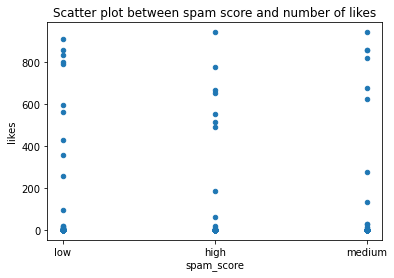

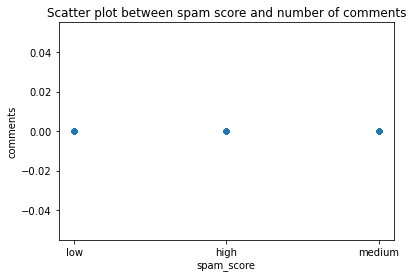

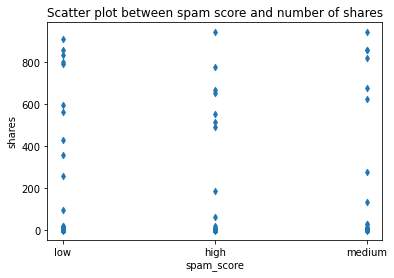

In [322]:
df.plot.scatter(x='spam_score', y='likes', title = "Scatter plot between spam score and number of likes")
df.plot.scatter(x='spam_score', y='comments', title = "Scatter plot between spam score and number of comments")
df.plot.scatter(x='spam_score', y='shares', title = "Scatter plot between spam score and number of shares", marker='d')
plt.show()

The scatter plot of the spam scores against likes, comments, shares and number of replies and participants on the tweet show that engagement via likes, shares, number of replies and number of participants is much lesser for tweets with a high spam score compared to tweets with a low and medium score. Interestingly, the number of comments on tweet from all three categories (low, medium and high) were the same.